# Sea ice density from AeN voyages

**Adam Steer**, Dmitry Divine, Bonnie Raffel, Anca Cristea


Knowing about the density of sea ice is critical for estimating its thickness and then volume from altimetry. It also helps provide information about the physical strength and structural behaviour of sea ice. Because sea ice density is highly variable and observations are sparse, the sea ice physical processes team in the Nansen Legacy Project (https://arvenetternansen.com/) collected ice cores for density profiling during research voyages in March, May and September 2021; and March 2022.

**Note:** this notebook is used for summarising density data. If you want see how data used here are generated, it is done in [this notebook](AeN-ice-density.ipynb)

## Ice core handling, storage and processing

Cores were collected using a Kovacs coring system with either a 70 mm (March and May 2021) or 90 mm  (September 2022, March 2022) diameter barrel. After collection, cores were stored intact in a freeezer at -20 C and returned to Tromsø. They were cut using a bandsaw in a freezer laboratory (-17 to -19 C) into 5 cm sections. Sections were then weighed in air and parafin (~829 kg / cubic meter). All equipment used for cutting and weighing, including parafin, was left in the freezer laboratory for some days ahead of cutting, to ensure stable temperatures.

Parafin density was measured each day of cutting. Any ice chunks dropped as part of handling were weighed again to ensure consistent results.

## Estimating density

Core section weights are converted to density based on archimedes bouyancy principle, where the density of a solid cane be computed from its weight in air, and then its weight in a liquid of known density:


$$ \rho ice = \frac{M air}{M air - M par} \rho par $$


... where $\rho ice$ is the computed density of the ice, $\rho par$ is the measured density of the parafin, $M air$ is the sample weight in air and $M par$ is the sample weight suspended in parafin. This is implemented in the function `computeDensity` below. This equation neglects density of air, which is assumed to affect sample weights in both air abd parafin equally.

### Density of light ice

Sometimes ice floats in parafin - it is less dense than the fluid. For those cases a method was developed using a denser object to 'weigh down' the target ice in parafin - referred to from here as `extra_weight`. Initially a chunk of fresh water ice was used. This involved cutting down the sea ice chunk after it had been immersed in parafin, so that both sea water and fresh water chunks fit in the parafin bath. It is a messy process and difficult to manage.

A new weighting method was developed using a stainless steel fishing lure with its hook removed. This has the advantage of less mess, although the lure is slippery - if light ice is suspected a few small cuts must be made in the top of ice sections, which can be carved out as a little cradle (before weighing) to help the lure stay in place.

The weight in parafin and air of the weighing object (ice or fishing lure) was recorded and density of the weighing object computed for each session. If the weighing object is dropped, it is weighed again in case its mass has changed.

Sea ice chunks were weighed by themselves in air. In parafin, the weighting object was carefully balanced on top of the ice to make sure it sank.

To work out the target ice density, a composite function is used:

$$\rho combined = (\rho ice * Pice) + (\rho extraweight * Pextraweight) $$

...where $P$ is the *relative volume* of each part. This is refactored to:

$$\rho ice = \frac{(\rho combined - (\rho extraweight * Pextraweight))}{Pice} $$

##### Getting component parts

The volume of the weight is computed in air:

$$ Vextraweight = \frac{Wextraweight}{\rho extraweight} $$

...as is the composite volume (sea ice plus weight):

$$ Vcomposite = \frac{Wcomposite}{\rho composite} $$

...and the relative volume of the fish is computed as:

$$ Pextraweight = \frac{Vextraweight}{Vcomposite} $$

The relative volume of sea ice is then:

$$ Pice = 1 - Pextraweight $$

Because these observations are few and the method is new, automated detection of when to use a composite density function is not implemented here. In future, a simple threshold by weight in parafin (>90 gm) might be enough.

### Set up python environment

In [5]:
# standard Python imports
import numpy as np
import os,sys
from scipy import stats
import csv

# Pandas
import pandas as pd

# matplotlib
from matplotlib import pyplot as plt


%matplotlib inline

%load_ext autoreload
%autoreload 2

In [6]:
# local function imports
sys.path.insert(0, os.path.abspath('../python-library/'))

# import a function which computes step plots with rounded corners

from plot_rounded_intervals import plot_rounded_intervals


In [7]:
def make_blockplot(dataframes, datasummary, ax, voyage_prefix):
    
    #colors=['r','g','b','k','y','c','m','orange','indigo','pink']
    
    
    colors = ['lightgray',
              'silver',
              'darkgrey',
              'darkgray',
              'grey',
              'gray',
              'dimgrey',
              'dimgray',
              'black',
              'orange',
              'green']
    
    i = 0
    legend_labels = []
    
    for key in datasummary.keys():
        
        print(key)
    
        p_ice = dataframes[key]["p_ice"].values
        p_ice_baseline = min(p_ice)
        
        legend_labels.append(key)
        
        core_intervals = dataframes[key]["min_depth"].values
        core_intervals = np.append(core_intervals, dataframes[key]["max_depth"].values[-1])
        
        #meandepth = dataframes[key]["min_depth"] + ((dataframes[key]["max_depth"] - dataframes[key]["min_depth"]) / 2)
       
        #plt.plot(p_ice, -meandepth, label=key)
        plot_rounded_intervals(-core_intervals, p_ice,
                               ax = ax, color = colors[i], rounding = (1, 1), baseline = p_ice_baseline)
        i += 1
        
    plt.legend(legend_labels)
    plt.title("Ice density profiles, " + voyage_prefix)
    plt.ylabel("Depth (0 is snow/ice interface), meters")
    plt.xlabel("Ice density (kg / m^3)")
    plt.grid()

In [8]:
def make_density_scatterplots(datasummary, plot_output_path):
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (21,7))

    ax1.scatter([float(x) for x in datasummary.iloc[19].values], [float(x) for x in datasummary.iloc[4].values], s = 50)

    ax1.grid()
    ax1.set_ylabel("Median density (kg/m3)")
    ax1.set_xlabel("Ice thickness (m)")
    ax1.set_title("Ice thickness and density")

    ax2.scatter([float(x) for x in datasummary.iloc[20].values], [float(x) for x in datasummary.iloc[4].values], c = 'g', s = 50)

    ax2.grid()
    ax2.set_xlabel("Ice freeboard (m)")
    ax2.set_title("Ice freeboard and density")

    icefreeboard = np.array([float(x) for x in datasummary.iloc[20].values])
    snow = np.array([float(x) for x in datasummary.iloc[21].values])

    tfb = icefreeboard+snow

    ax3.scatter(tfb, [float(x) for x in datasummary.iloc[4].values], c = 'c', s = 50)

    ax3.grid()
    ax3.set_xlabel("Total freeboard (m)")
    ax3.set_title("Total freeboard and density")

    plt.savefig(plot_output_path)
    
    return()

In [9]:
def gen_density_dataframes(data_path, prefix ):

    # initialise a dictionary for data  
    dataframes = {}

    # and one for metadata
    dataheaders = {}
    
    # intialise a list to hold file names.
    # this helps with geting data sorted in latitude order, low to high
    filenames = []
    
    # iterate over CSV files in a directory and read them into Pandas dataframes.
    # each core dataframe is an entry in the dictionary initialised above
    for f in os.listdir(data_path):

        # filter files - we want CSV files starting with Q1
        if f.endswith('.csv') and f.startswith(prefix):

            print(f)
            
            filenames.append(f)
            
            split_extension = os.path.splitext(f)

            # split the file name at dashes
            fileparts = split_extension[0].split("-")

            # make a dataframe name out of the file name parts
            dfname = fileparts[0] + "_" + fileparts[1] + "_" + fileparts[2]

            #read headers
            dataheaders[dfname] = pd.read_csv(data_path + f, nrows=18, header=None)
            #transpose the block so that row 1 is the field names
            dataheaders[dfname] = dataheaders[dfname].T[0:2]
            # create column names from the first row
            dataheaders[dfname].columns = dataheaders[dfname].iloc[0]
            # drop the first row bcause we don't need it now
            dataheaders[dfname] = dataheaders[dfname][1:]
            
            # read the CSV file into a dataframe
            dataframes[dfname] = pd.read_csv(data_path + f, skiprows=19)

            # add a computed density column
            dataframes[dfname]["p_ice"] = compute_density(dataframes[dfname])
            
    return dataframes, dataheaders

## Setting up a workflow

In [10]:
# set a data basepath

#linux
#data_path = "/mnt/documents/AeN-density/"

#windows
data_path = "../../Documents/AeN/AeN-icecores/density-aggregate-stats/"

In [11]:
density_summary = pd.read_csv(data_path + "q1_q2_jc2-2_j3_density_combined_summary_table.csv")

In [12]:
density_summary

Unnamed: 0  Q1_nleg6_main  Q1_P2_main  Q2_P3_main  Q2_P3_site2  \
0                     N       7.000000   19.000000   12.000000     5.000000   
1           density_min     913.150154  875.250529  866.503637   894.104203   
2           density_max     917.907246  915.116111  920.802635   912.340464   
3          density_mean     916.482503  899.680334  911.027350   906.813691   
4        density_median     917.176390  903.438820  914.872349   910.837684   
5           density_std       1.495469   11.219909   14.334318     6.922341   
6          density_skew      -1.407545   -0.727764   -2.402602    -1.016754   
7          salinity_min            NaN         NaN         NaN          NaN   
8          salinity_max            NaN         NaN         NaN          NaN   
9         salinity_mean            NaN         NaN         NaN          NaN   
10      salinity_median            NaN         NaN         NaN          NaN   
11         salinity_std            NaN         NaN         NaN          NaN   
12        salinity_skew            NaN         NaN         NaN          NaN   
13     conductivity_min            NaN         NaN         NaN          NaN   
14     conductivity_max            NaN         NaN         NaN          NaN   
15    conductivity_mean            NaN         NaN         NaN          NaN   
16  conductivity_median            NaN         NaN         NaN          NaN   
17     conductivity_std            NaN         NaN         NaN          NaN   
18    conductivity_skew            NaN         NaN         NaN          NaN   
19        ice_thickness       0.430000    1.325000    0.795000     0.320000   
20        ice_freeboard       0.020000    0.050000    0.010000     0.010000   
21           snow_depth       0.080000    0.210000    0.110000     0.110000   
22            longitude      34.014050   34.014050   33.997583    33.997583   
23             latitude      78.050768   78.050768   78.752917    78.752917   

    Q2_P4_main   Q2_P4_ROV  Q1_M2_main  Q1_P4_main  Q1_P4_ramses  ...  \
0     3.000000    3.000000   12.000000    7.000000      9.000000  ...   
1   904.630713  901.542806  879.447967  898.305591    866.297035  ...   
2   912.210591  911.595418  918.744268  916.911531    916.579879  ...   
3   908.595099  905.419750  909.959073  912.501259    904.506640  ...   
4   908.943993  903.121027  912.785719  914.312959    907.726867  ...   
5     3.104291    4.414133   10.700598    6.034262     14.092113  ...   
6    -0.167167    0.639918   -1.862554   -1.728540     -2.088972  ...   
7          NaN         NaN    3.700000    4.600000           NaN  ...   
8          NaN         NaN    7.000000   14.700000           NaN  ...   
9          NaN         NaN    5.108333    7.400000           NaN  ...   
10         NaN         NaN    5.000000    6.600000           NaN  ...   
11         NaN         NaN    0.939378    3.093311           NaN  ...   
12         NaN         NaN    0.434318    1.725952           NaN  ...   
13         NaN         NaN    6.740000    8.240000           NaN  ...   
14         NaN         NaN   12.320000   24.300000           NaN  ...   
15         NaN         NaN    9.119167   12.808571           NaN  ...   
16         NaN         NaN    8.945000   11.560000           NaN  ...   
17         NaN         NaN    1.569848    4.892380           NaN  ...   
18         NaN         NaN    0.453047    1.687702           NaN  ...   
19    0.190000    0.200000    0.600000    0.480000      0.590000  ...   
20    0.010000    0.010000    0.000000    0.000000      0.010000  ...   
21    0.080000    0.080000    0.165000    0.162000      0.130000  ...   
22   33.460000   33.460000   32.062000   33.615917     33.615917  ...   
23   79.600000   79.600000   79.687400   79.770817     79.770817  ...   

    Q1_P7_site2  JC3_P7_main  JC3_SiceK_main  Q2_P7_main  JC2_2_NLEG27  \
0      9.000000     7.000000       11.000000   19.000000      5.000000   
1    901.428819   900.772415      888.026562  898.893795    863

In [9]:
# check how the import went

q1_m2_data

min_depth  max_depth  temperature  salinity  conductivity    w_air  \
0       0.000      0.050         20.6       6.3         11.11  0.16962   
1       0.050      0.100         20.6       7.0         12.32  0.18643   
2       0.100      0.150         20.7       6.1         10.74  0.18569   
3       0.150      0.200         20.4       4.5          8.12  0.19825   
4       0.200      0.250         20.4       3.9          7.12  0.19863   
5       0.250      0.300         20.6       5.3          9.38  0.20000   
6       0.300      0.355         20.9       4.9          8.80  0.21124   
7       0.355      0.400         20.7       5.1          9.09  0.24894   
8       0.400      0.450         21.0       4.5          8.14  0.18147   
9       0.450      0.500         20.7       4.6          8.27  0.18811   
10      0.500      0.550         20.9       3.7          6.74  0.18330   
11      0.550      0.600         20.9       5.4          9.60  0.17209   

    w_parafin  parafin_density  extra_weight_air  extra_weight_parafin  
0     0.01347              829               NaN                   NaN  
1     0.01527              829               NaN                   NaN  
2     0.01689              829               NaN                   NaN  
3     0.01824              829               NaN                   NaN  
4     0.01819              829               NaN                   NaN  
5     0.01822              829               NaN                   NaN  
6     0.02010              829               NaN                   NaN  
7     0.01428              829               NaN                   NaN  
8     0.01739              829               NaN                   NaN  
9     0.01812              829               NaN                   NaN  
10    0.01774              829               NaN                   NaN  
11    0.01681              829               NaN                   NaN

In [10]:
# construct an intervals series from min_depth and max_depth - it should start at 0 and end at the 
# max depth, so we need only add the last element from max_depth to the min_depth series

core_intervals = q1_m2_data["min_depth"].values
core_intervals = np.append(core_intervals, q1_m2_data["max_depth"].values[-1])
core_intervals

array([0.   , 0.05 , 0.1  , 0.15 , 0.2  , 0.25 , 0.3  , 0.355, 0.4  ,
       0.45 , 0.5  , 0.55 , 0.6  ])

In [11]:
# add another column for computed density

q1_m2_data["p_ice"] = compute_density(q1_m2_data)

Text(0, 0.5, 'ice core depth (meters, 0 is top of core)')

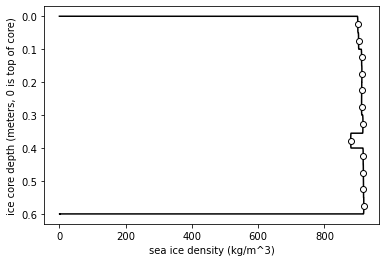

In [12]:
# plot the profile just to take a look 

plot_rounded_intervals(core_intervals, q1_m2_data["p_ice"].values, rounding = (1, 1))
plt.xlabel("sea ice density (kg/m^3)")
plt.ylabel("ice core depth (meters, 0 is top of core)")

## Plotting and summarising Q1 densities

Now there is a workflow developed, apply it to all the density cores, voyage at a time for now.

Q1 is winter sea ice, sampled in March 2021

In [14]:
q1dataframes, q1dataheaders = gen_density_dataframes(data_path + "Q1-2021/density/raw/", 'Q1-')

Q1-M2-main-core.csv
Q1-nleg6-main-core.csv
Q1-P2-main-core.csv
Q1-P4-main-core.csv
Q1-P4-ramses-core.csv
Q1-P5-main-core.csv
Q1-P6-main-core.csv
Q1-P7-main-core.csv
Q1-P7-site2-core.csv


In [15]:
# check what is in the dictionary
q1dataframes.keys()

dict_keys(['Q1_M2_main', 'Q1_nleg6_main', 'Q1_P2_main', 'Q1_P4_main', 'Q1_P4_ramses', 'Q1_P5_main', 'Q1_P6_main', 'Q1_P7_main', 'Q1_P7_site2'])

In [16]:
q1dataheaders["Q1_M2_main"]["timestamp"].values[0]

'21-03-2021T09:00:00.00'

In [17]:
q1dataframes["Q1_M2_main"][0:5]

min_depth  max_depth  temperature  salinity  conductivity    w_air  \
0       0.00       0.05         20.6       6.3         11.11  0.16962   
1       0.05       0.10         20.6       7.0         12.32  0.18643   
2       0.10       0.15         20.7       6.1         10.74  0.18569   
3       0.15       0.20         20.4       4.5          8.12  0.19825   
4       0.20       0.25         20.4       3.9          7.12  0.19863   

   w_parafin  parafin_density  extra_weight_air  extra_weight_parafin  \
0    0.01347              829               NaN                   NaN   
1    0.01527              829               NaN                   NaN   
2    0.01689              829               NaN                   NaN   
3    0.01824              829               NaN                   NaN   
4    0.01819              829               NaN                   NaN   

        p_ice  
0  900.512200  
1  902.959044  
2  911.949111  
3  913.000667  
4  912.570771

Q1_M2_main
Q1_nleg6_main
Q1_P2_main
Q1_P4_main
Q1_P4_ramses
Q1_P5_main
Q1_P6_main
Q1_P7_main
Q1_P7_site2


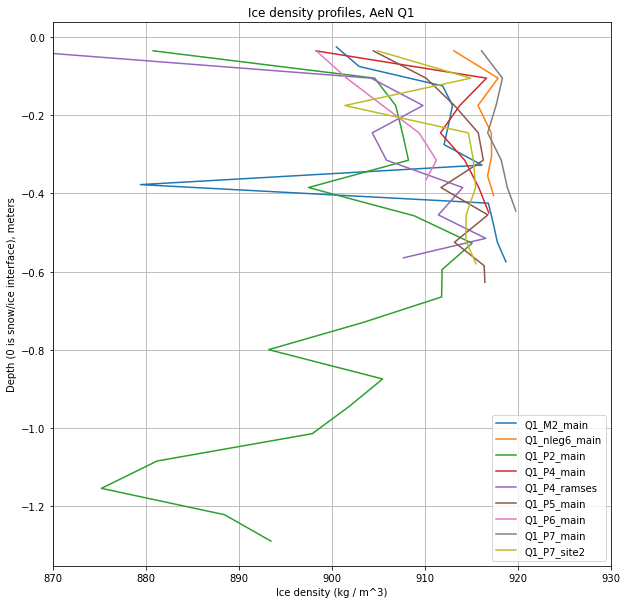

In [21]:
fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(111)

make_lineplot(q1dataframes, "AeN Q1")

ax.set_xlim(870,930)

plt.savefig(data_path + "Q1-2021/density/plots/q1-lineplot.png")
#plt.savefig("/mnt/documents/AeN-density/Q1-plot.png")

In [22]:
# create a data summary dataframe
q1datasummary = aggregatestats(q1dataframes, q1dataheaders)

C:\Users\ADAM~1.STE\AppData\Local\Temp/ipykernel_6332/1478234445.py:161: RuntimeWarning: All-NaN axis encountered
  thestats.append(np.nanmin(dataframes[key]["salinity"]))
C:\Users\ADAM~1.STE\AppData\Local\Temp/ipykernel_6332/1478234445.py:162: RuntimeWarning: All-NaN axis encountered
  thestats.append(np.nanmax(dataframes[key]["salinity"]))
C:\Users\ADAM~1.STE\AppData\Local\Temp/ipykernel_6332/1478234445.py:163: RuntimeWarning: Mean of empty slice
  thestats.append(np.nanmean(dataframes[key]["salinity"]))
C:\Users\Adam.Steer\Miniconda3\envs\iceanalysis\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Users\Adam.Steer\Miniconda3\envs\iceanalysis\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\ADAM~1.STE\AppData\Local\Temp/ipykernel_6332/1478234445.

In [23]:
q1datasummary.sort_values(by="latitude", axis=1, inplace=True)

In [24]:
q1datasummary

Q1_nleg6_main  Q1_P2_main  Q1_M2_main  Q1_P4_main  \
N                               7          19          12           7   
density_min            913.150154  875.250529  879.447967  898.305591   
density_max            917.907246  915.116111  918.744268  916.911531   
density_mean           916.482503  899.680334  909.959073  912.501259   
density_median          917.17639   903.43882  912.785719  914.312959   
density_std              1.495469   11.219909   10.700598    6.034262   
density_skew            -1.407545   -0.727764   -1.862554    -1.72854   
salinity_min                  NaN         NaN         3.7         4.6   
salinity_max                  NaN         NaN         7.0        14.7   
salinity_mean                 NaN         NaN    5.108333         7.4   
salinity_median               NaN         NaN         5.0         6.6   
salinity_std                  NaN         NaN    0.939378    3.093311   
salinity_skew                 NaN         NaN    0.434318    1.725952   
conductivity_min              NaN         NaN        6.74        8.24   
conductivity_max              NaN         NaN       12.32        24.3   
conductivity_mean             NaN         NaN    9.119167   12.808571   
conductivity_median           NaN         NaN       8.945       11.56   
conductivity_std              NaN         NaN    1.569848     4.89238   
conductivity_skew             NaN         NaN    0.453047    1.687702   
ice_thickness                0.43       1.325         0.6        0.48   
ice_freeboard                0.02        0.05           0           0   
snow_depth                   0.08        0.21       0.165       0.162   
longitude                34.01405    34.01405      32.062   33.615917   
latitude               78.0507683  78.0507683     79.6874   79.770817   

                    Q1_P4_ramses  Q1_P5_main  Q1_P6_main  Q1_P7_main  \
N                              9          10           6           7   
density_min           866.297035  904.483325  898.353313  916.125611   
density_max           916.579879  916.806854  911.276482  919.814927   
density_mean           904.50664  913.463812   906.04891  917.990547   
density_median        907.726867  914.495388   907.44206  918.247379   
density_std            14.092113     3.70179    4.735704    1.157767   
density_skew           -2.088972   -1.259792    -0.45963   -0.125808   
salinity_min                 NaN         5.1         NaN         NaN   
salinity_max                 NaN        10.0         NaN         NaN   
salinity_mean                NaN        6.63         NaN         NaN   
salinity_median              NaN        6.55         NaN         NaN   
salinity_std                 NaN    1.271259         NaN         NaN   
salinity_skew                NaN    1.578512         NaN         NaN   
conductivity_min             NaN        9.22         NaN         NaN   
conductivity_max             NaN       17.13         NaN         NaN   
conductivity_mean            NaN      11.672         NaN         NaN   
conductivity_median          NaN      11.585         NaN         NaN   
conductivity_std             NaN    2.056841         NaN         NaN   
conductivity_skew            NaN    1.581123         NaN         NaN   
ice_thickness               0.59       0.645        0.38        0.47   
ice_freeboard               0.01         0.1           0        0.03   
snow_depth                  0.13        0.21        0.14        0.07   
longitude              33.615917     33.9927   31.319883   29.986175   
latitude               79.770817    80.39165    81.51725   81.996928   

                    Q1_P7_site2  
N                             9  
density_min          901.428819  
density_max          915.527279  
density_mean         912.352654  
density_median       914.702597  
density_std            4.989478  
density_skew          -1.411842  
salinity_min                3.9  
salinity_max                6.1  
salinity_mean               4.8  
salinity_median    

In [25]:
q1datasummary.to_csv(data_path + "Q1-2021/density/" + "q1_2021_density_summary_table.csv")

Q1_nleg6_main
Q1_P2_main
Q1_M2_main
Q1_P4_main
Q1_P4_ramses
Q1_P5_main
Q1_P6_main
Q1_P7_main
Q1_P7_site2


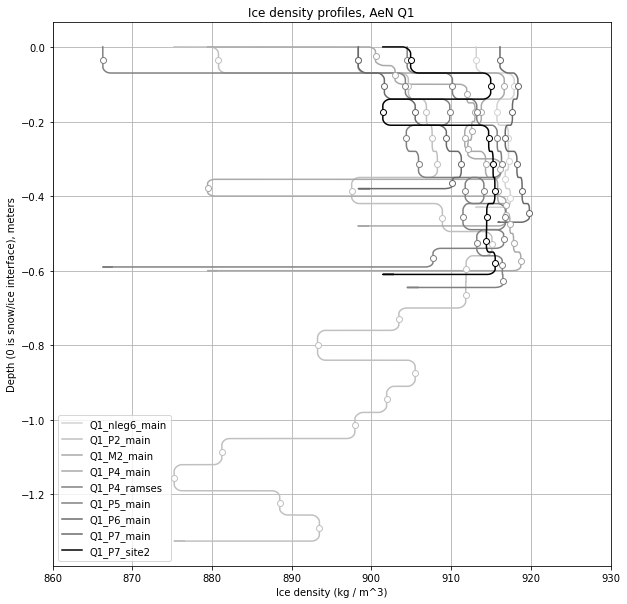

In [26]:
fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(111)

make_blockplot(q1dataframes, q1datasummary, ax, "AeN Q1")

ax.set_xlim(860, 930)

plt.savefig(data_path + "/Q1-2021/density/plots/q1-squareplot.png")

()

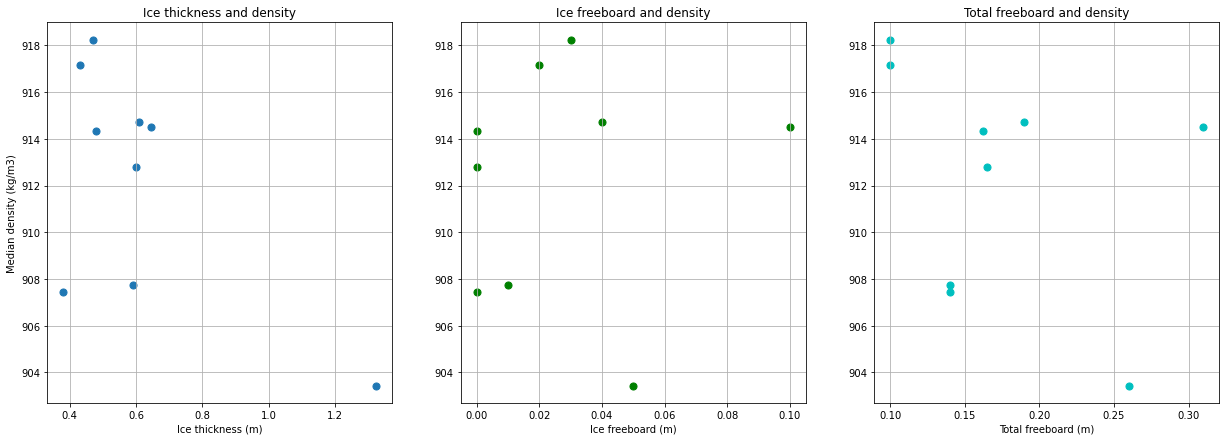

In [27]:
make_density_scatterplots(q1datasummary, data_path + "Q1-2021/density/plots/"+
                          "q1_density_freeboard_scatterplots.png")

In [29]:
gen_output_data(q1dataheaders, q1dataframes, data_path + "Q1-2021/density/processed/", "Q1_2021")

## Plotting and summarising Q2 density profiles

Early spring, May 2021. New ice still forming

In [30]:
# initialise a dictionary for data
q2dataframes, q2dataheaders = gen_density_dataframes(data_path + "Q2-2021/density/raw/", "Q2-")


Q2-P3-main-core.csv
Q2-P3-site2-core.csv
Q2-P4-main-core.csv
Q2-P4-ROV-core.csv
Q2-P5-main-core.csv
Q2-P6-main-core.csv
Q2-P6-optics-core.csv
Q2-P7-main-core.csv


Q2_P3_main
Q2_P3_site2
Q2_P4_main
Q2_P4_ROV
Q2_P5_main
Q2_P6_main
Q2_P6_optics
Q2_P7_main


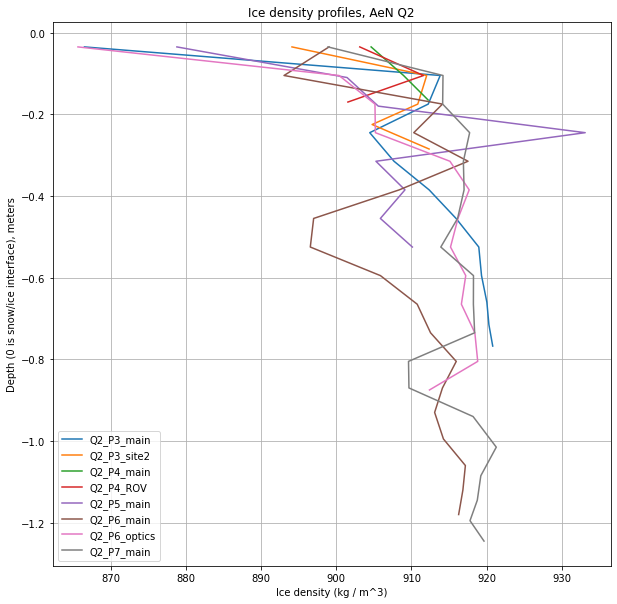

In [31]:
fig = plt.figure(figsize = (10,10))

make_lineplot(q2dataframes, "AeN Q2")

plt.savefig(data_path + "Q2-2021/density/plots/q2-lineplot.png")

In [32]:
q2datasummary = aggregatestats(q2dataframes, q2dataheaders)
q2datasummary.sort_values(by="latitude", axis=1, inplace=True)

C:\Users\ADAM~1.STE\AppData\Local\Temp/ipykernel_6332/1478234445.py:161: RuntimeWarning: All-NaN axis encountered
  thestats.append(np.nanmin(dataframes[key]["salinity"]))
C:\Users\ADAM~1.STE\AppData\Local\Temp/ipykernel_6332/1478234445.py:162: RuntimeWarning: All-NaN axis encountered
  thestats.append(np.nanmax(dataframes[key]["salinity"]))
C:\Users\ADAM~1.STE\AppData\Local\Temp/ipykernel_6332/1478234445.py:163: RuntimeWarning: Mean of empty slice
  thestats.append(np.nanmean(dataframes[key]["salinity"]))
C:\Users\Adam.Steer\Miniconda3\envs\iceanalysis\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Users\Adam.Steer\Miniconda3\envs\iceanalysis\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\ADAM~1.STE\AppData\Local\Temp/ipykernel_6332/1478234445.

In [33]:
q2datasummary

Q2_P3_main Q2_P3_site2  Q2_P4_main   Q2_P4_ROV  \
N                            12           5           3           3   
density_min          866.503637  894.104203  904.630713  901.542806   
density_max          920.802635  912.340464  912.210591  911.595418   
density_mean          911.02735  906.813691  908.595099   905.41975   
density_median       914.872349  910.837684  908.943993  903.121027   
density_std           14.334318    6.922341    3.104291    4.414133   
density_skew          -2.402602   -1.016754   -0.167167    0.639918   
salinity_min                NaN         NaN         NaN         NaN   
salinity_max                NaN         NaN         NaN         NaN   
salinity_mean               NaN         NaN         NaN         NaN   
salinity_median             NaN         NaN         NaN         NaN   
salinity_std                NaN         NaN         NaN         NaN   
salinity_skew               NaN         NaN         NaN         NaN   
conductivity_min            NaN         NaN         NaN         NaN   
conductivity_max            NaN         NaN         NaN         NaN   
conductivity_mean           NaN         NaN         NaN         NaN   
conductivity_median         NaN         NaN         NaN         NaN   
conductivity_std            NaN         NaN         NaN         NaN   
conductivity_skew           NaN         NaN         NaN         NaN   
ice_thickness             0.795        0.32        0.19         0.2   
ice_freeboard              0.01        0.01        0.01        0.01   
snow_depth                 0.11        0.11        0.08        0.08   
longitude             33.997583   33.997583       33.46       33.46   
latitude              78.752917   78.752917        79.6        79.6   

                     Q2_P5_main  Q2_P6_main Q2_P6_optics  Q2_P7_main  
N                             8          18           13          19  
density_min          878.798823  893.047547   865.639437  898.893795  
density_max          933.103313  917.517669   918.807438  921.277257  
density_mean         906.162042  909.598231   909.535804  915.678153  
density_median        905.72198  912.806285   915.188636  917.734156  
density_std           13.796062    7.720279    13.881594    4.976261  
density_skew          -0.045323   -0.939184    -2.358132   -2.041522  
salinity_min                NaN         NaN          NaN         NaN  
salinity_max                NaN         NaN          NaN         NaN  
salinity_mean               NaN         NaN          NaN         NaN  
salinity_median             NaN         NaN          NaN         NaN  
salinity_std                NaN         NaN          NaN         NaN  
salinity_skew               NaN         NaN          NaN         NaN  
conductivity_min            NaN         NaN          NaN         NaN  
conductivity_max            NaN         NaN          NaN         NaN  
conductivity_mean           NaN         NaN          NaN         NaN  
conductivity_median         NaN         NaN          NaN         NaN  
conductivity_std            NaN         NaN          NaN         NaN  
conductivity_skew           NaN         NaN          NaN         NaN  
ice_thickness              0.56        1.21         0.91        1.27  
ice_freeboard              0.02       0.075        0.075       0.105  
snow_depth                0.227        0.23         0.23       0.165  
longitude               33.6152     30.8281      30.8281    28.72301  
latitude                80.5498     81.5629      81.5629     82.2224

In [34]:
q2datasummary.to_csv(data_path + "Q2-2021/density/q2_2021_density_summary_table.csv")

Q2_P3_main
Q2_P3_site2
Q2_P4_main
Q2_P4_ROV
Q2_P5_main
Q2_P6_main
Q2_P6_optics
Q2_P7_main


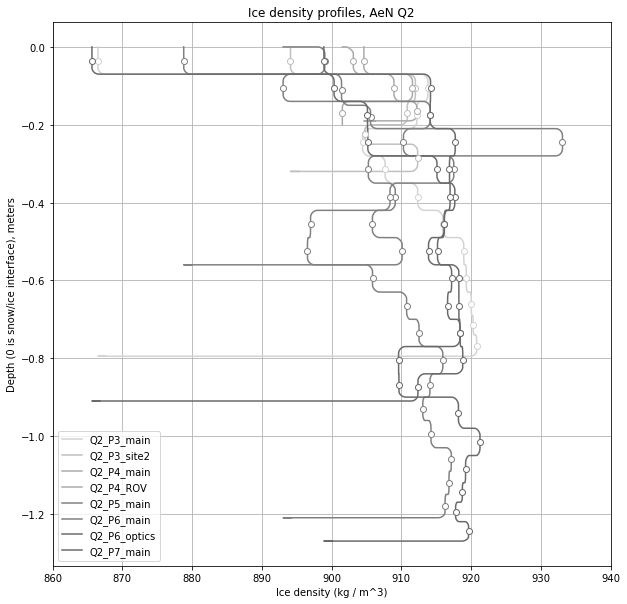

In [35]:
fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(111)

make_blockplot(q2dataframes, q2datasummary, ax, "AeN Q2")

ax.set_xlim(860, 940)

plt.savefig(data_path + "/Q2-2021/density/plots/q2-squareplot.png")

()

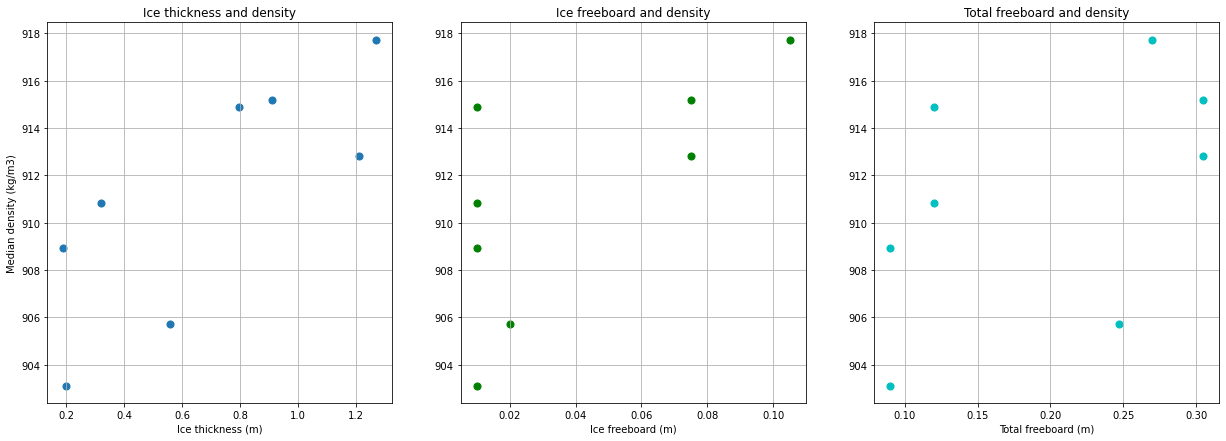

In [36]:
make_density_scatterplots(q2datasummary, data_path + "Q2-2021/density/plots/" +
                          "q2_density_freeboard_scatterplots.png")

In [37]:
gen_output_data(q2dataheaders, q2dataframes, data_path + "Q2-2021/density/processed/", "Q2_2021")

## Putting Q1 and Q2 2021 data together

...here, looking for any relationships between altimetry-relevant properties and sea ice density

In [38]:
allthesummary = q1datasummary.copy()
allthesummary = allthesummary.join(q2datasummary)

In [39]:
allthesummary.sort_values(by="latitude", axis=1, inplace=True)

In [40]:
allthesummary

Q1_nleg6_main  Q1_P2_main  Q2_P3_main Q2_P3_site2  \
N                               7          19          12           5   
density_min            913.150154  875.250529  866.503637  894.104203   
density_max            917.907246  915.116111  920.802635  912.340464   
density_mean           916.482503  899.680334   911.02735  906.813691   
density_median          917.17639   903.43882  914.872349  910.837684   
density_std              1.495469   11.219909   14.334318    6.922341   
density_skew            -1.407545   -0.727764   -2.402602   -1.016754   
salinity_min                  NaN         NaN         NaN         NaN   
salinity_max                  NaN         NaN         NaN         NaN   
salinity_mean                 NaN         NaN         NaN         NaN   
salinity_median               NaN         NaN         NaN         NaN   
salinity_std                  NaN         NaN         NaN         NaN   
salinity_skew                 NaN         NaN         NaN         NaN   
conductivity_min              NaN         NaN         NaN         NaN   
conductivity_max              NaN         NaN         NaN         NaN   
conductivity_mean             NaN         NaN         NaN         NaN   
conductivity_median           NaN         NaN         NaN         NaN   
conductivity_std              NaN         NaN         NaN         NaN   
conductivity_skew             NaN         NaN         NaN         NaN   
ice_thickness                0.43       1.325       0.795        0.32   
ice_freeboard                0.02        0.05        0.01        0.01   
snow_depth                   0.08        0.21        0.11        0.11   
longitude                34.01405    34.01405   33.997583   33.997583   
latitude               78.0507683  78.0507683   78.752917   78.752917   

                     Q2_P4_main   Q2_P4_ROV  Q1_M2_main  Q1_P4_main  \
N                             3           3          12           7   
density_min          904.630713  901.542806  879.447967  898.305591   
density_max          912.210591  911.595418  918.744268  916.911531   
density_mean         908.595099   905.41975  909.959073  912.501259   
density_median       908.943993  903.121027  912.785719  914.312959   
density_std            3.104291    4.414133   10.700598    6.034262   
density_skew          -0.167167    0.639918   -1.862554    -1.72854   
salinity_min                NaN         NaN         3.7         4.6   
salinity_max                NaN         NaN         7.0        14.7   
salinity_mean               NaN         NaN    5.108333         7.4   
salinity_median             NaN         NaN         5.0         6.6   
salinity_std                NaN         NaN    0.939378    3.093311   
salinity_skew               NaN         NaN    0.434318    1.725952   
conductivity_min            NaN         NaN        6.74        8.24   
conductivity_max            NaN         NaN       12.32        24.3   
conductivity_mean           NaN         NaN    9.119167   12.808571   
conductivity_median         NaN         NaN       8.945       11.56   
conductivity_std            NaN         NaN    1.569848     4.89238   
conductivity_skew           NaN         NaN    0.453047    1.687702   
ice_thickness              0.19         0.2         0.6        0.48   
ice_freeboard              0.01        0.01           0           0   
snow_depth                 0.08        0.08       0.165       0.162   
longitude                 33.46       33.46      32.062   33.615917   
latitude                   79.6        79.6     79.6874   79.770817   

                    Q1_P4_ramses  Q1_P5_main  Q2_P5_main  Q1_P6_main  \
N                              9          10           8           6   
density_min           866.297035  904.483325  878.798823  898.353313   
density_max           916.579879  916.806854  933.103313  911.276482   
density_mean           904.50664  913.463812  906.162042   906.04891   
density_median        907.726867  914.495388   905.72198  

In [41]:
allthesummary.to_csv(data_path + "density-aggregate-stats/" +
                     "q1_q2_density_combined_summary_table.csv")

()

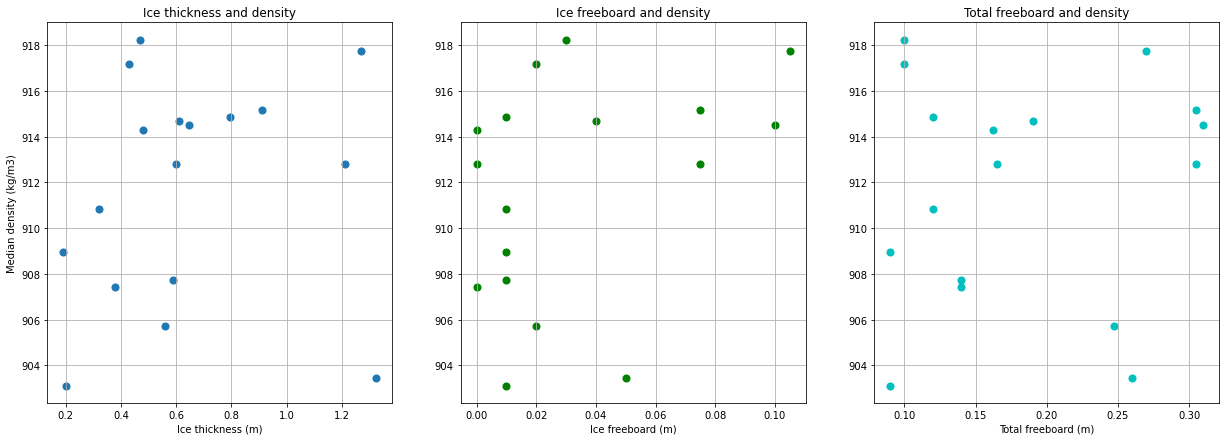

In [42]:
make_density_scatterplots(allthesummary, data_path + "density-aggregate-stats/" +
                          "q1_q2_combined_density_freeboard_scatterplots.png")

## AeN JC2-2 density profiles

Late summer, September 2021 - starting to refreeze

In [43]:
# initialise a dictionary for data
jc2dataframes, jc2dataheaders = gen_density_dataframes(data_path + "JC2-2-2021/density/raw/", "JC2-2-")

JC2-2-NLEG27-main.csv
JC2-2-NLEG40.5-main.csv
{'w_air': 0.23492, 'w_parafin': 0.13143, 'p_density': 829.0, 'w_fish_air': 0.14067, 'w_fish_parafin': 0.1291}
{'w_air': 0.27776, 'w_parafin': 0.14962, 'p_density': 829.0, 'w_fish_air': 0.14067, 'w_fish_parafin': 0.1291}
JC2-2-P10-main.csv
{'w_air': 0.38124, 'w_parafin': 0.11777, 'p_density': 829.0, 'w_fish_air': 0.14016, 'w_fish_parafin': 0.12868}
JC2-2-P11-main.csv
{'w_air': 0.1552, 'w_parafin': 0.12867, 'p_density': 829.0, 'w_fish_air': 0.14041, 'w_fish_parafin': 0.12891}
{'w_air': 0.23068, 'w_parafin': 0.131, 'p_density': 829.0, 'w_fish_air': 0.14041, 'w_fish_parafin': 0.12891}
JC2-2-P8-main.csv
JC2-2-P9-lead.csv
JC2-2-P9-main.csv
{'w_air': 0.23355, 'w_parafin': 0.004, 'p_density': 829.0, 'w_fish_air': 0.0967, 'w_fish_parafin': 0.00861}
{'w_air': 0.24361, 'w_parafin': 0.0056, 'p_density': 829.0, 'w_fish_air': 0.0967, 'w_fish_parafin': 0.00861}
{'w_air': 0.24205, 'w_parafin': 0.00796, 'p_density': 829.0, 'w_fish_air': 0.09894, 'w_fish_par

In [44]:
jc2datasummary = aggregatestats(jc2dataframes, jc2dataheaders)
jc2datasummary.sort_values(by="latitude", axis=1, inplace=True)

In [45]:
jc2datasummary

JC2_2_NLEG27 JC2_2_NLEG40.5    JC2_2_P8    JC2_2_P9  \
N                              5             15          18          37   
density_min           863.197079     837.304613  848.311732  812.953267   
density_max           871.883303     937.688605  907.027683  915.124237   
density_mean          869.258998     886.157445  885.592205  893.796219   
density_median        870.865986     890.377821  890.007992  904.895308   
density_std             3.227902      23.000879   18.021644   25.673981   
density_skew           -1.114708       0.059132   -0.465909   -1.950505   
salinity_min                 0.4            1.1         0.4         0.1   
salinity_max                 0.8            4.6         2.5         3.5   
salinity_mean               0.64       2.906667    1.444444    2.081081   
salinity_median              0.7            2.7        1.45         2.4   
salinity_std            0.162481       0.939125    0.736525    1.110354   
salinity_skew          -0.380465       0.252609   -0.080857   -0.295271   
conductivity_min           1.013           2.21       1.006       0.311   
conductivity_max           1.709           8.24         4.6        6.48   
conductivity_mean         1.3824       5.355333    2.804611    3.910243   
conductivity_median        1.397           5.03        2.77        4.46   
conductivity_std        0.286829       1.621867    1.291025    1.958986   
conductivity_skew      -0.071789       0.179038   -0.071894    -0.32054   
ice_thickness               0.26           0.72        0.91        1.77   
ice_freeboard               0.01           0.08         0.1        0.24   
snow_depth                  0.13           0.04        0.03        0.04   
longitude                  27.91          -8.23     25.4114       7.434   
latitude                   82.94          83.85     83.8994      85.374   

                      JC2_2_P10   JC2_2_P11  
N                            20          30  
density_min          805.936402  827.720021  
density_max          907.554668  914.656648  
density_mean         882.645445  895.954914  
density_median       886.127002  901.476536  
density_std           23.854373   19.867033  
density_skew          -1.617691   -2.235823  
salinity_min                0.9         0.3  
salinity_max                3.0         4.4  
salinity_mean              1.93        2.46  
salinity_median            2.15        2.65  
salinity_std            0.65123    0.953799  
salinity_skew         -0.207816   -0.741691  
conductivity_min          1.894       0.676  
conductivity_max           5.62        7.98  
conductivity_mean        3.6784    4.589333  
conductivity_median       4.095        4.95  
conductivity_std       1.160287    1.681555  
conductivity_skew     -0.204313   -0.792445  
ice_thickness              0.97         1.5  
ice_freeboard              0.01        0.14  
snow_depth                 0.15        0.07  
longitude                -16.75     -17.601  
latitude                 86.493      87.484

In [46]:
jc2datasummary.to_csv(data_path + "JC2-2-2021/density/" +
                      "jc2-2-2021_density_summary_table.csv")

JC2_2_NLEG27
JC2_2_NLEG40.5
JC2_2_P10
JC2_2_P11
JC2_2_P8
JC2_2_P9


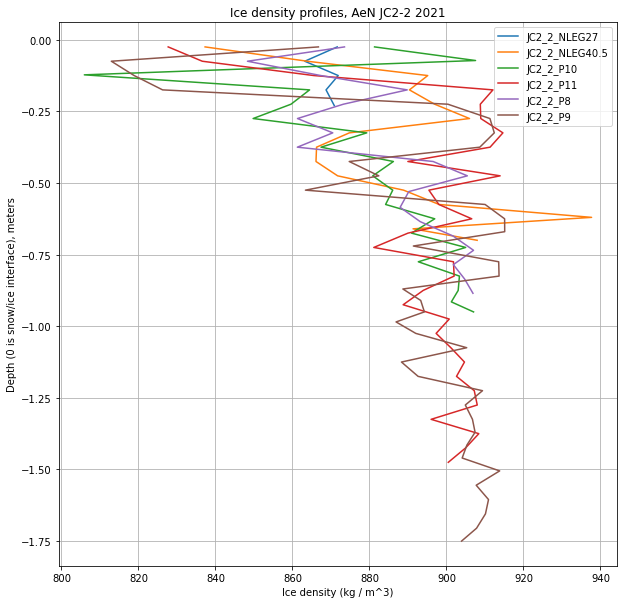

In [47]:
fig = plt.figure(figsize = (10,10))

make_lineplot(jc2dataframes, "AeN JC2-2 2021")

plt.savefig(data_path + "JC2-2-2021/density/plots/jc2-2-lineplot.png")

JC2_2_NLEG27
JC2_2_NLEG40.5
JC2_2_P8
JC2_2_P9
JC2_2_P10
JC2_2_P11


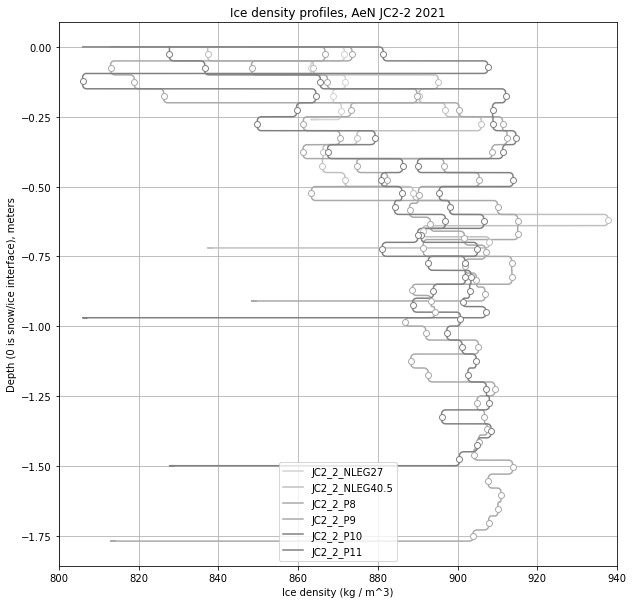

In [48]:
fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(111)

make_blockplot(jc2dataframes, jc2datasummary, ax, "AeN JC2-2 2021")

ax.set_xlim(800, 940)

plt.savefig(data_path + "JC2-2-2021/density/plots/jc2-2-squareplot.png")

In [49]:
gen_output_data(jc2dataheaders, jc2dataframes, data_path + "JC2-2-2021/density/processed/", "JC2-2_2021")

()

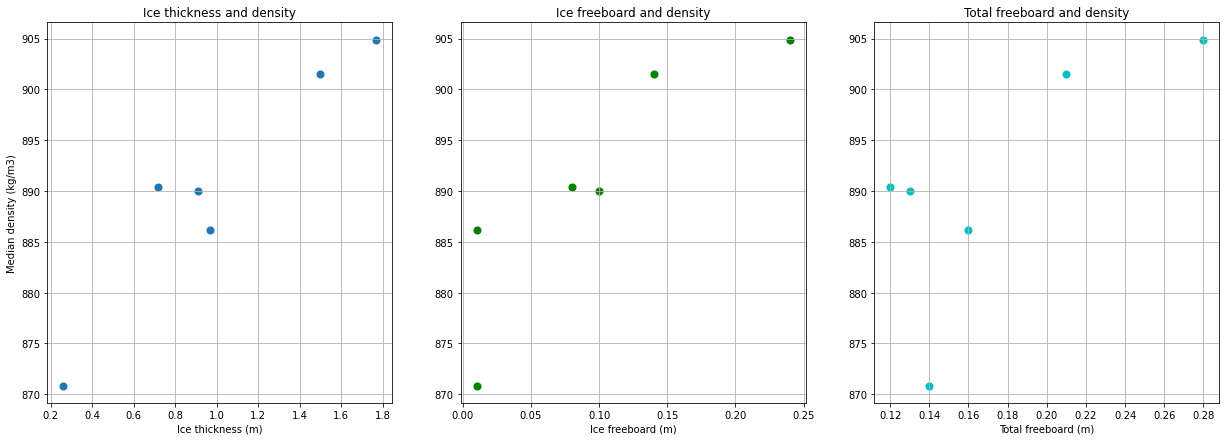

In [50]:
make_density_scatterplots(jc2datasummary, data_path + "JC2-2-2021/density/plots/"+
                          "jc2-2_density_freeboard_scatterplots.png")

### Putting Q1, Q2, JC2-2 summary data together

In [51]:
allthesummary = allthesummary.join(jc2datasummary)
allthesummary.sort_values(by="latitude", axis=1, inplace=True)

()

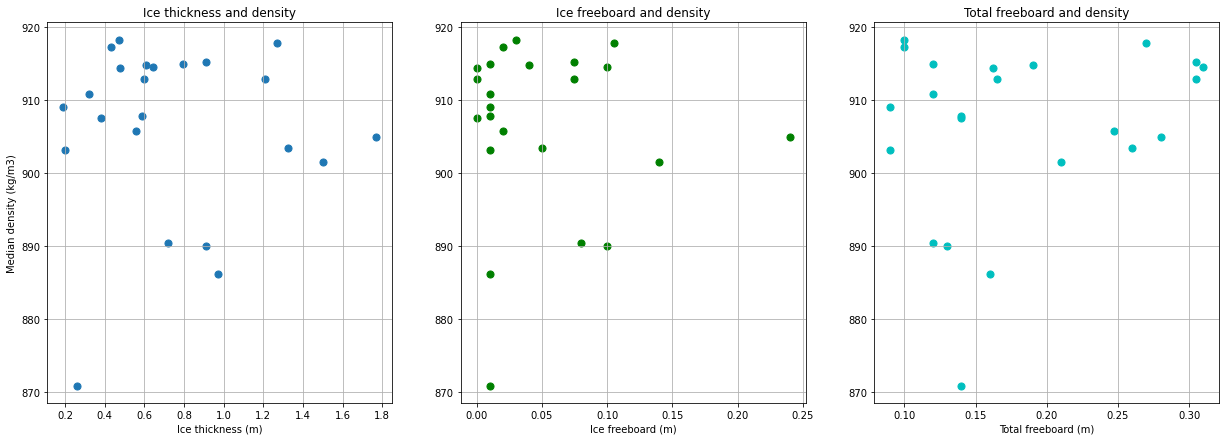

In [52]:
make_density_scatterplots(allthesummary, data_path + "density-aggregate-stats/" + 
                          "q1_q2_jc2-2_combined_density_freeboard_scatterplots.png")

In [53]:
allthesummary.to_csv(data_path + "density-aggregate-stats/" +
                     "q1_q2_jc2-2_density_combined_summary_table.csv")

## JC3 2022 density profiles

Winter sea ice, collected March 2022

In [54]:
# initialise a dictionary for data
jc3dataframes, jc3dataheaders = gen_density_dataframes(data_path + "JC3-2022/density/raw/", "JC3-")

JC3-P5-main.csv
JC3-P5-thinice.csv
JC3-P7-main.csv
JC3-SiceK-main.csv


In [55]:
jc3datasummary = aggregatestats(jc3dataframes, jc3dataheaders)
jc3datasummary.sort_values(by="latitude", axis=1, inplace=True)

In [56]:
jc3datasummary

JC3_P5_main JC3_P5_thinice JC3_P7_main JC3_SiceK_main
N                            12              6           7             11
density_min          852.499353     859.448836  900.772415     888.026562
density_max          918.788211     928.915632  916.812617     962.214072
density_mean         902.244158     889.703502  911.622014     918.178552
density_median       914.461465     889.927112  913.806693     910.699243
density_std           19.602763       23.16473    5.003193      21.893952
density_skew          -1.282243       0.298078   -1.208388       1.172913
salinity_min                4.8            3.6         3.2            3.6
salinity_max               13.4           13.0         8.7            7.4
salinity_mean          7.683333       8.033333    5.371429       4.636364
salinity_median            6.95           7.55         5.4            4.2
salinity_std           2.309341       3.624301    1.713571       1.030686
salinity_skew          1.283874       0.125921    0.638193       1.639043
conductivity_min           8.58           6.53        5.92           6.59
conductivity_max           22.3           21.7       14.96          12.82
conductivity_mean     13.315833      13.793333    9.535714       8.304545
conductivity_median      12.205          13.06        9.57           7.55
conductivity_std       3.680089       5.845088    2.815299       1.705085
conductivity_skew      1.230843       0.108894    0.605448       1.575253
ice_thickness              0.57            0.3        0.34           0.52
ice_freeboard              0.05           0.02      -0.015              0
snow_depth                 0.03           0.03        0.11           0.19
longitude             33.989474      33.989474    29.47693       29.47693
latitude              80.690343      80.690343    82.04626       82.04626

In [57]:
jc2datasummary.to_csv(data_path + "JC3-2022/density/jc3-2022_density_summary_table.csv")

JC3_P5_main
JC3_P5_thinice
JC3_P7_main
JC3_SiceK_main


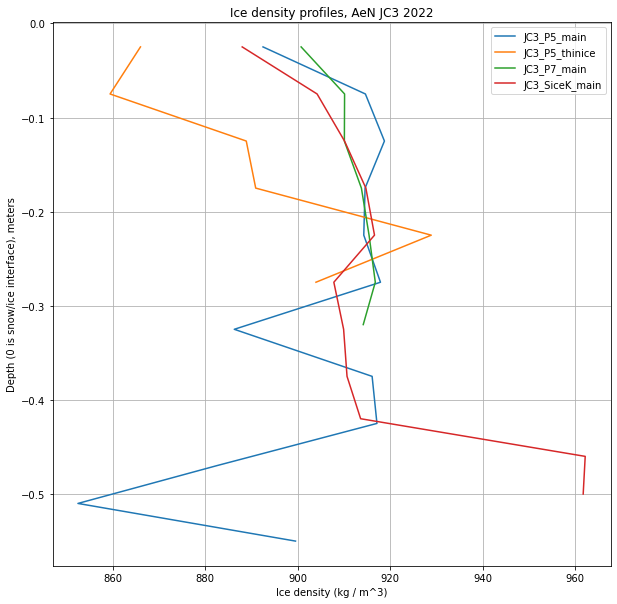

In [58]:
fig = plt.figure(figsize = (10,10))

make_lineplot(jc3dataframes, "AeN JC3 2022")

plt.savefig(data_path + "JC3-2022/density/plots/jc3-2022-lineplot.png")

JC3_P5_main
JC3_P5_thinice
JC3_P7_main
JC3_SiceK_main


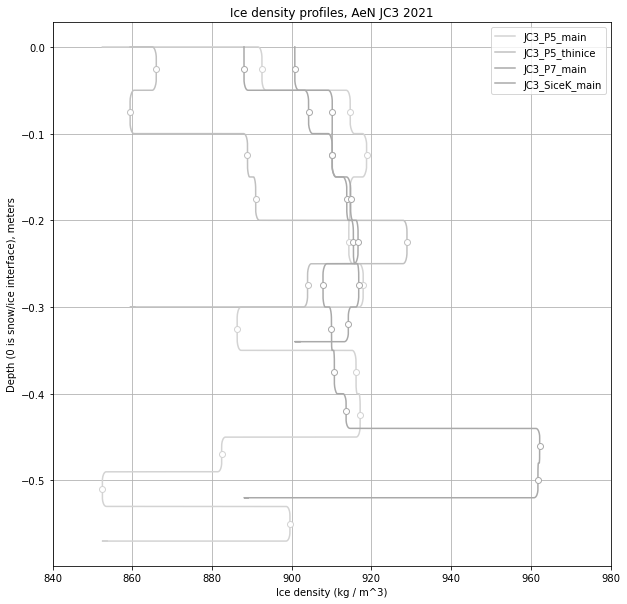

In [59]:
fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(111)

make_blockplot(jc3dataframes, jc3datasummary, ax, "AeN JC3 2021")

ax.set_xlim(840, 980)

plt.savefig(data_path + "JC3-2022/density/plots/jc3-2022-squareplot.png")

In [60]:
gen_output_data(jc3dataheaders, jc3dataframes, data_path + "JC3-2022/density/processed/", "JC3_2022")

### Compile all the data so far

In [61]:
allthesummary = allthesummary.join(jc3datasummary)
allthesummary.sort_values(by="latitude", axis=1, inplace=True)

()

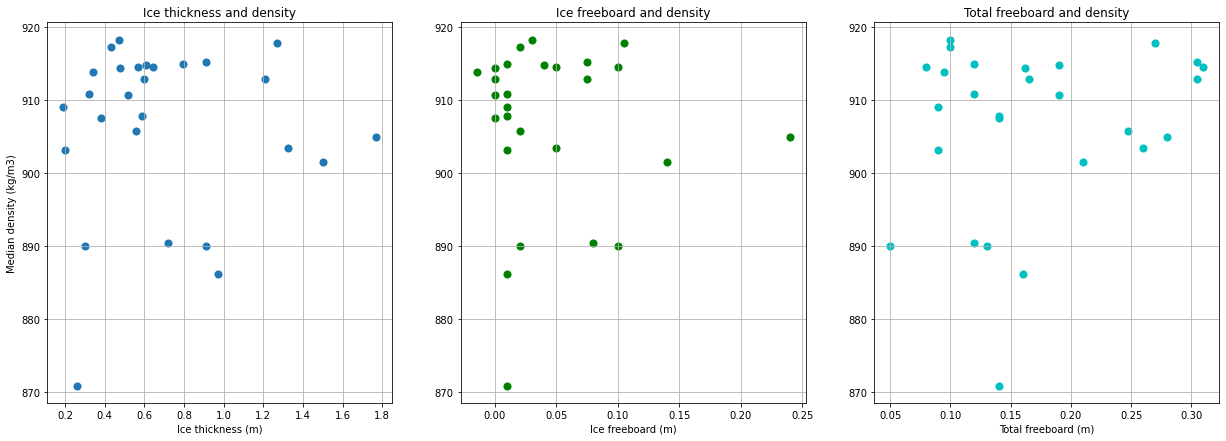

In [62]:
make_density_scatterplots(allthesummary, data_path + "density-aggregate-stats/" +
                          "q1_q2_jc2-2_jc3_combined_density_freeboard_scatterplots.png")

In [63]:
allthesummary.to_csv(data_path + "density-aggregate-stats/" +
                     "q1_q2_jc2-2_j3_density_combined_summary_table.csv")

In [64]:
allthesummary

Q1_nleg6_main  Q1_P2_main  Q2_P3_main Q2_P3_site2  \
N                               7          19          12           5   
density_min            913.150154  875.250529  866.503637  894.104203   
density_max            917.907246  915.116111  920.802635  912.340464   
density_mean           916.482503  899.680334   911.02735  906.813691   
density_median          917.17639   903.43882  914.872349  910.837684   
density_std              1.495469   11.219909   14.334318    6.922341   
density_skew            -1.407545   -0.727764   -2.402602   -1.016754   
salinity_min                  NaN         NaN         NaN         NaN   
salinity_max                  NaN         NaN         NaN         NaN   
salinity_mean                 NaN         NaN         NaN         NaN   
salinity_median               NaN         NaN         NaN         NaN   
salinity_std                  NaN         NaN         NaN         NaN   
salinity_skew                 NaN         NaN         NaN         NaN   
conductivity_min              NaN         NaN         NaN         NaN   
conductivity_max              NaN         NaN         NaN         NaN   
conductivity_mean             NaN         NaN         NaN         NaN   
conductivity_median           NaN         NaN         NaN         NaN   
conductivity_std              NaN         NaN         NaN         NaN   
conductivity_skew             NaN         NaN         NaN         NaN   
ice_thickness                0.43       1.325       0.795        0.32   
ice_freeboard                0.02        0.05        0.01        0.01   
snow_depth                   0.08        0.21        0.11        0.11   
longitude                34.01405    34.01405   33.997583   33.997583   
latitude               78.0507683  78.0507683   78.752917   78.752917   

                     Q2_P4_main   Q2_P4_ROV  Q1_M2_main  Q1_P4_main  \
N                             3           3          12           7   
density_min          904.630713  901.542806  879.447967  898.305591   
density_max          912.210591  911.595418  918.744268  916.911531   
density_mean         908.595099   905.41975  909.959073  912.501259   
density_median       908.943993  903.121027  912.785719  914.312959   
density_std            3.104291    4.414133   10.700598    6.034262   
density_skew          -0.167167    0.639918   -1.862554    -1.72854   
salinity_min                NaN         NaN         3.7         4.6   
salinity_max                NaN         NaN         7.0        14.7   
salinity_mean               NaN         NaN    5.108333         7.4   
salinity_median             NaN         NaN         5.0         6.6   
salinity_std                NaN         NaN    0.939378    3.093311   
salinity_skew               NaN         NaN    0.434318    1.725952   
conductivity_min            NaN         NaN        6.74        8.24   
conductivity_max            NaN         NaN       12.32        24.3   
conductivity_mean           NaN         NaN    9.119167   12.808571   
conductivity_median         NaN         NaN       8.945       11.56   
conductivity_std            NaN         NaN    1.569848     4.89238   
conductivity_skew           NaN         NaN    0.453047    1.687702   
ice_thickness              0.19         0.2         0.6        0.48   
ice_freeboard              0.01        0.01           0           0   
snow_depth                 0.08        0.08       0.165       0.162   
longitude                 33.46       33.46      32.062   33.615917   
latitude                   79.6        79.6     79.6874   79.770817   

                    Q1_P4_ramses  Q1_P5_main  ... Q1_P7_site2 JC3_P7_main  \
N                              9          10  ...           9           7   
density_min           866.297035  904.483325  ...  901.428819  900.772415   
density_max           916.579879  916.806854  ...  915.527279  916.812617   
density_mean           904.50664  913.463812  ...  912.352654  911.622014   
density_median        907.726867 

## Is there a pattern between location and density?

the plots below shows a little bit of clustering around higher density and south-ness, and higher density and east-ness. It should be noted that all cores collected north of 82 degrees and west of approximately 18 degrees are from September sea ice, that has survived at least one summer in the Arctic and is beginning to refreeze. These were all collected on JC2-2 in 2021

The clusters show a well-observed phenomena - that newer ice tends to be denser than older ice. It is useful to note that for all data, the lack of relationship between thickness or freeboard and density still holds.

Text(0.5, 1.0, 'Ice thickness and longitude')

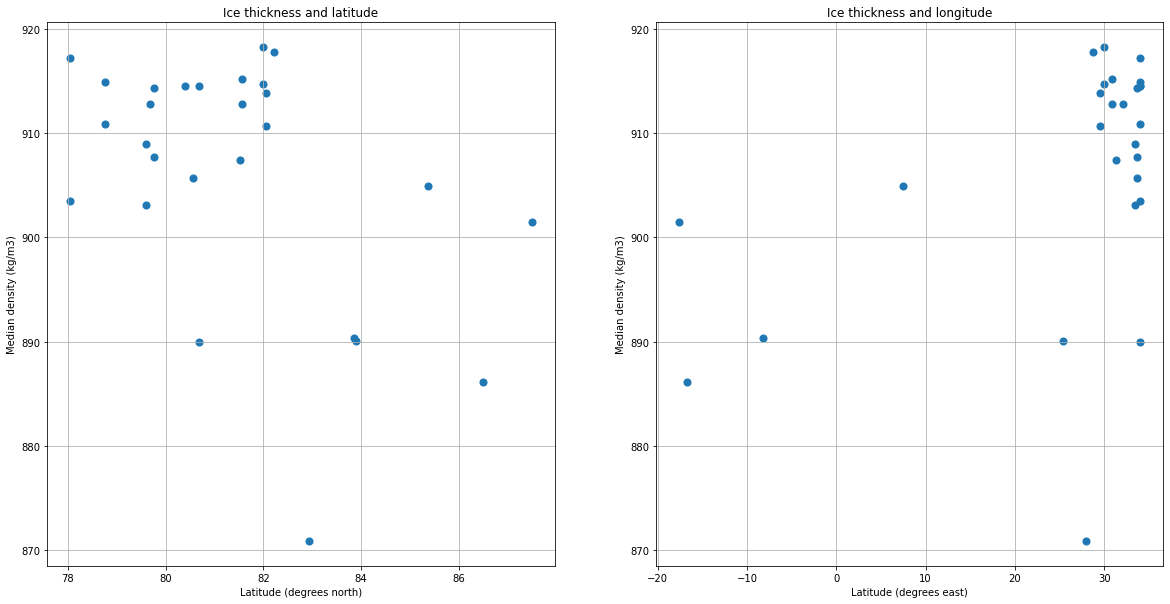

In [65]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (20,10))

ax1.scatter([float(x) for x in allthesummary.iloc[23].values], [float(x) for x in allthesummary.iloc[4].values], s = 50)

ax1.grid()
ax1.set_ylabel("Median density (kg/m3)")
ax1.set_xlabel("Latitude (degrees north)")
ax1.set_title("Ice thickness and latitude")


ax2.scatter([float(x) for x in allthesummary.iloc[22].values], [float(x) for x in allthesummary.iloc[4].values], s = 50)

ax2.grid()
ax2.set_ylabel("Median density (kg/m3)")
ax2.set_xlabel("Latitude (degrees east)")
ax2.set_title("Ice thickness and longitude")

## Uncertainties in density measurement

Like most work on sea ice density, these observations carry uncertainty. The scales we use will deliver weights in milligrams - however, because the scales were affected by the freezer fans it is likely best to apply a maximum precision of 0.1 grams.

Measuring the density of parafin using a hygrometer, our best effort to read the scale is 0.001 g / cm^3.

The function `densityVcv` implements variace-covariance propagation of measurement uncertainties through Archimedes' buoyancy equation:

In [66]:
def densityVcv(uParafin, uScale, wAir, wParafin):
    
    """
    """

### plotting density and uncertainty

plots of densities with uncertainties

### Density and ice class

Can we apply a rule of thumb about ice classes from the Norwegian Ice Service charts, and density of sea ice?

## Summary

This notebook shows how to read AeN ice core density data and provides the complete process from reading data logs from the weighing process, to density estimates. It also shows how a summary table for futher analysis is built.

Simple density profile plots are provided, along with scatter plots which show how density and various other ice parameters (eg freeboard, thickness) are, in this case, more or less completely decoupled.

## References


Pustogvar, A., and A. Kulyakhtin. "Sea Ice Density Measurements. Methods and Uncertainties." Cold Regions Science and Technology 131 (November 2016): 46–52. https://doi.org/10.1016/j.coldregions.2016.09.001.

Kern, S., K. Khvorostovsky, H. Skourup, E. Rinne, Z. S. Parsakhoo, V. Djepa, P. Wadhams, and S. Sandven. "The Impact of Snow Depth, Snow Density and Ice Density on Sea Ice Thickness Retrieval from Satellite Radar Altimetry: Results from the ESA-CCI Sea Ice ECV Project Round Robin Exercise." The Cryosphere 9, no. 1 (January 6, 2015): 37–52. https://doi.org/10.5194/tc-9-37-2015.

Hutchings, Jennifer K., Petra Heil, Oliver Lecomte, Roger Stevens, Adam Steer, and Jan L. Lieser. "Comparing Methods of Measuring Sea-Ice Density in the East Antarctic." Annals of Glaciology 56, no. 69 (2015): 77–82. https://doi.org/10.3189/2015AoG69A814.

Timco, G.W., Weeks, W.F., 2010. A review of the engineering properties of sea ice. Cold Regions Science and Technology 60, 107–129. https://doi.org/10.1016/j.coldregions.2009.10.003
